In [1]:
%pylab inline
import math
from numba import jit ## requires numba packages, you need to install it for this HW

Populating the interactive namespace from numpy and matplotlib


## (Extra Credit) Problem 1

Python is an interpretive language, however, there are tools that can compile Python code on the fly and allows almost native execution speed in some cases. One of such tools is the numba just im time (JIT) compiler. The following is an implementation of the fast inverse normal CDF function, which can be used to convert uniform random numbers to normal random numbers. Note the @jit declaration in the code, which activates the numba JIT compiler for the following python function.

In [58]:
@jit
def ltqnorm( p ):
    """
    Modified from the author's original perl code (original comments follow below)
    by dfield@yahoo-inc.com.  May 3, 2004.

    Lower tail quantile for standard normal distribution function.

    This function returns an approximation of the inverse cumulative
    standard normal distribution function.  I.e., given P, it returns
    an approximation to the X satisfying P = Pr{Z <= X} where Z is a
    random variable from the standard normal distribution.

    The algorithm uses a minimax approximation by rational functions
    and the result has a relative error whose absolute value is less
    than 1.15e-9.

    Author:      Peter John Acklam
    Time-stamp:  2000-07-19 18:26:14
    E-mail:      pjacklam@online.no
    WWW URL:     http://home.online.no/~pjacklam
    """

    if p <= 0 or p >= 1:
        return np.nan

    # Coefficients in rational approximations.
    a = (-3.969683028665376e+01,  2.209460984245205e+02, \
         -2.759285104469687e+02,  1.383577518672690e+02, \
         -3.066479806614716e+01,  2.506628277459239e+00)
    b = (-5.447609879822406e+01,  1.615858368580409e+02, \
         -1.556989798598866e+02,  6.680131188771972e+01, \
         -1.328068155288572e+01 )
    c = (-7.784894002430293e-03, -3.223964580411365e-01, \
         -2.400758277161838e+00, -2.549732539343734e+00, \
          4.374664141464968e+00,  2.938163982698783e+00)
    d = ( 7.784695709041462e-03,  3.224671290700398e-01, \
          2.445134137142996e+00,  3.754408661907416e+00)

    # Define break-points.
    plow  = 0.02425
    phigh = 1 - plow

    # Rational approximation for lower region:
    if p < plow:
       q  = math.sqrt(-2*math.log(p))
       return (((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5]) / \
               ((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+1)

    # Rational approximation for upper region:
    if phigh < p:
       q  = math.sqrt(-2*math.log(1-p))
       return -(((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5]) / \
                ((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+1)

    # Rational approximation for central region:
    q = p - 0.5
    r = q*q
    return (((((a[0]*r+a[1])*r+a[2])*r+a[3])*r+a[4])*r+a[5])*q / \
           (((((b[0]*r+b[1])*r+b[2])*r+b[3])*r+b[4])*r+1)
    

@jit
def ninv_vec(xs) :
    return np.array(map(ltqnorm, xs))

1. use the above code to inverse 1 million equally sampled numbers btw 0 and 1, compare it with the build in scipy.stat.norm.ppf function to verify that the absolute error is on the order of $10^{-9}$. Is there a different btw the first run and the subsequent runs with the @jit flag on?
2. remove the @git flag, and repeat 1, note the speed difference.

## Problem 2

This problem explores the expoential log Euler and the Milstein scheme on the following CIR process:

$$ d r(t) = \kappa (\bar{r} - r(t)) dt + \sigma \sqrt{r(t)} dw(t)$$

with: $\kappa = 0.1, \bar{r} = 0.03, \sigma = 0.05, r(0) = 0.01$, all the parameters are annualized.

It was taught in many text book that when sampling the above CIR process, one way to avoid the negative value is to flip the sign of the random normal random number if it would lead to negative $r$ values in the next simulation step. This makes the $r(t)=0$ a reflective boundary.

1. what is the analytical expression of  $\mathbb E [r(t)]$, you can cite a reference to answer this question, but it is useful for you to understand how it was derived (no need to write it in your answers).
2. implement the Euler discretizaitaon with the reflective boundary, run the simulation to compute the average of $r(10Y)$ with reflective boundary using different time sample step sizes, and plot the bias at 10Y as a function of the time sample step sizes.
3. repeat 2, but using the log Euler sampling and comment on your results
4. repeat, but use the Milstein scheme
4. draw a few paths from all three methods using the same set random numbers and show that they are indeed path-wise equivalent for paths that do not hit zero (path wise equivalence guaranteed by Ito's lemma); also show a few paths that have different behaviours near $r(t) = 0$.

Hint: in the log Euler step, the log(r(t)) can become very negative, leading to a underflow to 0. in the exp() function. You can apply a reflective cap/floor on the log(r(t)) to avoid the under flow problem. 

## Problem 3

Consider two dimensional OU processes:

$$\begin{array} {l}
d x(t) &= \kappa_x (\mu_x - x(t)) dt + \sigma_x dw_x(t) \\
d y(t) &= \kappa_y (\mu_y - y(t)) dt + \sigma_y dw_y(t) \\
\end{array}$$

with the following parameterization: 

In [46]:
kx, ux, volx = .5, .05, .05
ky, uy, voly = .1, .02, .01
rho_xy = .5 # correlation between dw_x and dw_y
x0, y0 = .01, .01

1. simulate the correlated process to 1Y using Euler discretization, using 100 time steps, i.e., $dt = 0.01$. Estimate the correlation between the final values of $x(t=1Y), y(t=1Y)$. Is the simulated correlation the same as the correlation between $dw_x, dw_y$? 
3. [optional] derive the analytical formula for the correlation between the terminal value of $x(t)$ and $y(t)$, and verify it with the numerical simulation results.

## (Extra Credit) Problem 4

Price a American call option using LSMC, assuming:
* initial stock price and option strikes: $s(0) = k = 100$
* continuounsly compounded discount rate $r = 0.02$
* continuous dividend yield is $y = 0.1$
* stock volatility $\sigma = 0.25$
* option expiry: $t = 1Y$

You need to produce the following output:
1. European and American option prices
2. Exercise boundary

For this exercise, obviously you should not use the mc package provided as part of the lecture, you need to implement you own Americal LSMC pricer.

### Solution

In [72]:
t, m, r, y, s0, k, vol = 1., 52, .02, .1, 100, 100, .25

dt = t/m 
n = 100000

ts = np.arange(1, m+1)*dt

gbm = proc.GBM(r-y, vol)
spath = gbm.draw(np.random.normal(size=[n, m]), s0, dt)

ecall = np.maximum(spath[:,-1]-k, 0)*np.exp(-r*t)
u = np.mean(ecall)
e = np.std(ecall)/sqrt(n)

print "European call price is %.2f, MC err %.2g" % (u, e) 

European call price is 6.02, MC err 0.041


In [70]:
import mc

call_ev = lambda x : np.maximum(x - k, 0)
v_b, e_b, b_b, cvs = mc.amer_opt(spath, exp(-r*dt), call_ev, mc.fit_ex)

print "American put value from LSMC is %.3f" % v_b

American put value from LSMC is 6.961


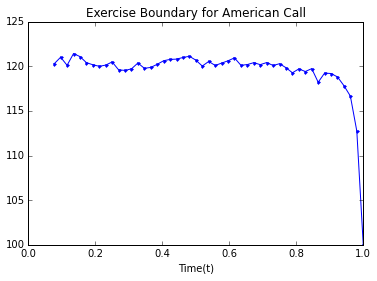

In [56]:
plot(ts, b_b + k, '.-');
xlabel('Time(t)')
title('Exercise Boundary for American Call');